In [1]:
import numpy as np
import torch
import torchOptics.optics as tt
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import torchOptics.metrics as tm
import torchvision
import torchkbnufft


meta = {'wl' : (638e-9), 'dx':(17e-6, 17e-6)}

In [14]:
import torch
# from torchkbnufft import KbNufft, KbNufftAdjoint
import torchkbnufft.modules as kb
import matplotlib.pyplot as plt

def band_extended_angular_spectrum_method_2d(input_field, λ, dx, dy, N, z):
    # Parameters (adjust as needed)
    # Number of points in source window (per axis)
    # z = 1000 * (N * dx)  # Propagation distance [m]
    total_points = 2 * N # Total points after zero-padding
    
    # Calculate extended bandwidth (same for x/y in symmetric case)
    f_extend = np.sqrt(N / (2 * λ * z))  # From paper Eq. (6) approximation
    
    # Generate 2D non-uniform frequency grid
    f_x = torch.linspace(-f_extend, f_extend, total_points)
    f_y = torch.linspace(-f_extend, f_extend, total_points)
    fx_grid, fy_grid = torch.meshgrid(f_x, f_y, indexing='ij')
    
    # Convert to NUFFT coordinates (radians/sample)
    coordinates_x = 2 * torch.pi * fx_grid.flatten() * dx
    coordinates_y = 2 * torch.pi * fy_grid.flatten() * dy
    coordinates = torch.stack((coordinates_x, coordinates_y), dim=0)
    
    # Create 2D input field (square aperture with zero-padding)
    if input_field == None:
        g = torch.zeros((total_points, total_points), dtype=torch.complex64)
        pad = (total_points - N) // 2
        g[pad:pad+N, pad:pad+N] = 1.0
    else:
        padding = torchvision.transforms.Pad((total_points - N) // 2)
        g = padding(input_field)
    # Initialize NUFFT objects for 2D
    nufft_ob = kb.KbNufft(im_size=(total_points, total_points)).cuda()
    adjoint_nufft_ob = kb.KbNufftAdjoint(im_size=(total_points, total_points)).cuda()
    print(g.shape, coordinates.shape)
    # Forward NUFFT (2D uniform spatial to non-uniform frequency)
    G = nufft_ob(
        g.unsqueeze(0).unsqueeze(0).cuda(),  # Add batch, coil, 2D dims
        coordinates.unsqueeze(0).cuda()                   # Add batch dimension
    )
    
    # Compute 2D transfer function H(f_x, f_y)
    k = 2 * torch.pi / λ
    f_term = (λ**2) * (fx_grid**2 + fy_grid**2)
    valid_mask = f_term <= 1.0
    phase = torch.zeros_like(f_term)
    phase[valid_mask] = k * z * torch.sqrt(1 - f_term[valid_mask])
    H = torch.exp(1j * phase).flatten().type(torch.complex64).cuda()
    
    # Apply transfer function
    A = G * H
    print(A.shape, coordinates.shape)
    # Inverse NUFFT (non-uniform frequency to uniform spatial)
    u = adjoint_nufft_ob(
        A,  # Add batch, coil, 2D dims
        coordinates.unsqueeze(0).cuda()                   # Add batch dimension
    )
    crop = torchvision.transforms.CenterCrop(input_field.shape[-1])
    # Reshape and return output field
    return crop(u.squeeze()), g


def plt_show(field):
    plt.imshow(field.detach().cpu().numpy())
    plt.colorbar()
    plt.show()

torch.Size([2048, 2048]) torch.Size([2, 4194304])
torch.Size([1, 1, 4194304]) torch.Size([2, 4194304])


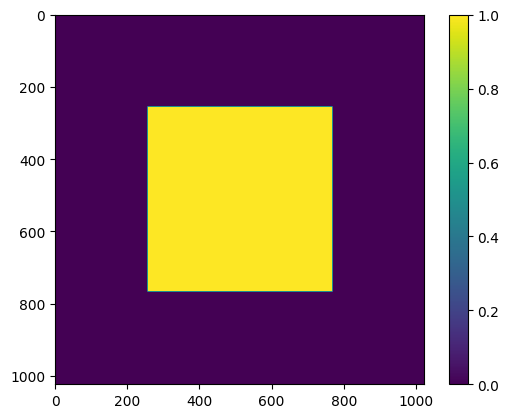

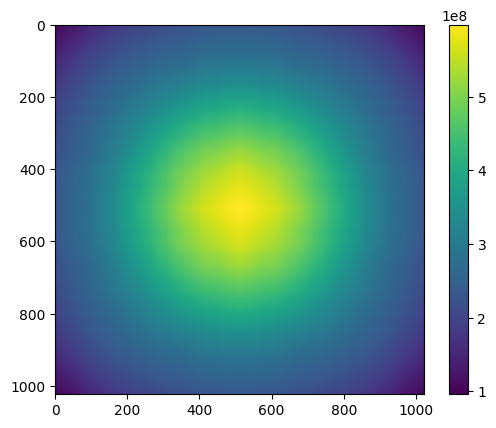

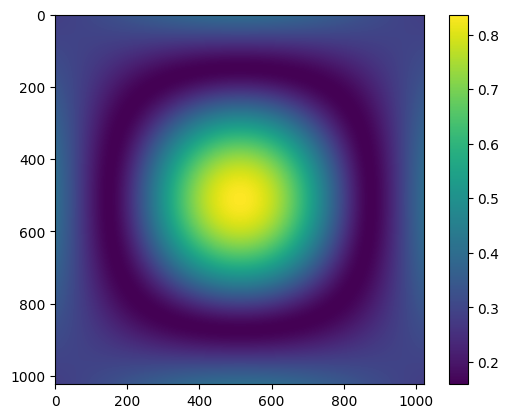

In [18]:
N = 1024
input_field = torch.zeros((N, N))
input_field[256:768, 256:768] = 1.0
input_field = input_field.to(torch.complex64)
wl = 500e-9
dx, dy = 1e-6, 1e-6
z = 800 * N * dx
output_field, input_field_ = band_extended_angular_spectrum_method_2d(input_field, wl, dx, dy, N, z)
plt_show(input_field.abs())
plt_show(output_field.abs())
meta = {'dx':(dx, dx), 'wl':(wl)}
input_field = tt.Tensor(input_field, meta=meta)
tt_sim = tt.simulate(input_field, z).abs()
plt_show(tt_sim)

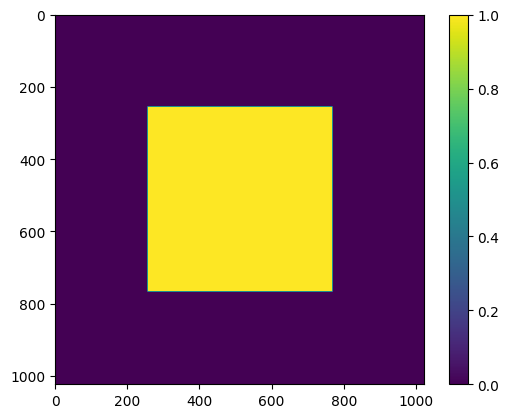

In [34]:
plt_show(input_field.abs())

In [57]:
def compare_BE_BL(alpha):
    N = 1024
    input_field = torch.zeros((N, N))
    input_field[256:768, 256:768] = 1.0
    input_field = input_field.to(torch.complex64)
    wl = 500e-9
    dx, dy = 1e-6, 1e-6
    z = alpha * N * dx
    output_field, input_field_ = band_extended_angular_spectrum_method_2d(input_field, wl, dx, dy, N, z)
    # plt_show(input_field.abs())
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.title(f'{alpha}S, band extended')
    plt.imshow(output_field.abs().detach().cpu().numpy())
    plt.colorbar()
    meta = {'dx':(dx, dx), 'wl':(wl)}
    input_field = tt.Tensor(input_field, meta=meta)
    tt_sim = tt.simulate(input_field, z, padding=512)
    plt.subplot(122)
    plt.title(f'{alpha}S, band limited')
    plt.imshow(tt_sim.abs().detach().cpu().numpy())
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.title(f'{alpha}S, band extended')
    plt.imshow(output_field.angle().detach().cpu().numpy())
    plt.colorbar()
    
    plt.subplot(122)
    plt.title(f'{alpha}S, band limited')
    plt.imshow(tt_sim.angle().detach().cpu().numpy())
    plt.colorbar()
    
    
    psnr = tt.relativeLoss(output_field.abs().cuda(), tt_sim.abs().cuda(), tm.get_PSNR)
    print('PSNR : ', psnr)

torch.Size([2048, 2048]) torch.Size([2, 4194304])
torch.Size([1, 1, 4194304]) torch.Size([2, 4194304])


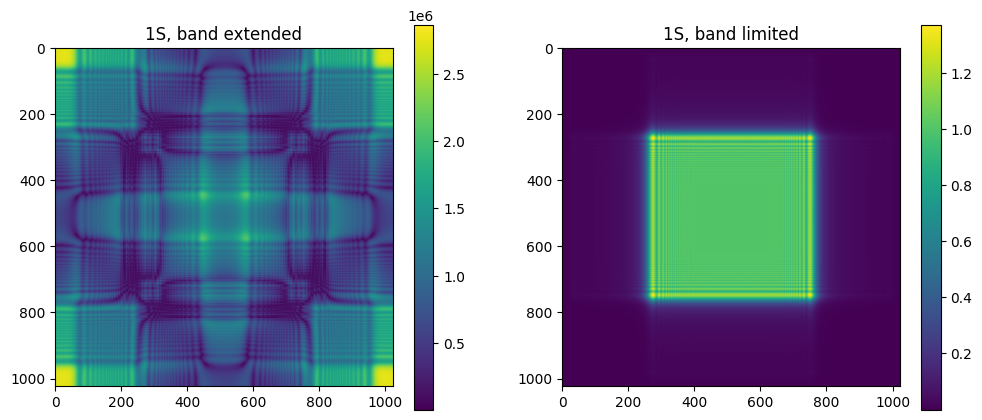

PSNR :  9.737438201904297


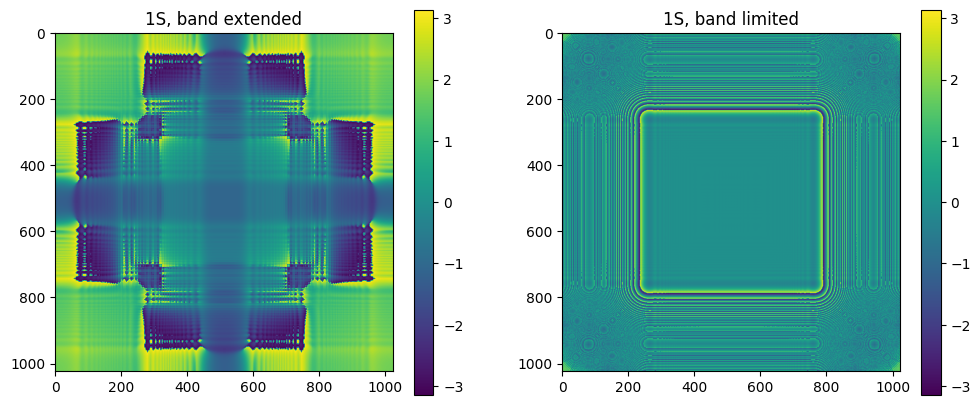

In [58]:
compare_BE_BL(1)

torch.Size([2048, 2048]) torch.Size([2, 4194304])
torch.Size([1, 1, 4194304]) torch.Size([2, 4194304])


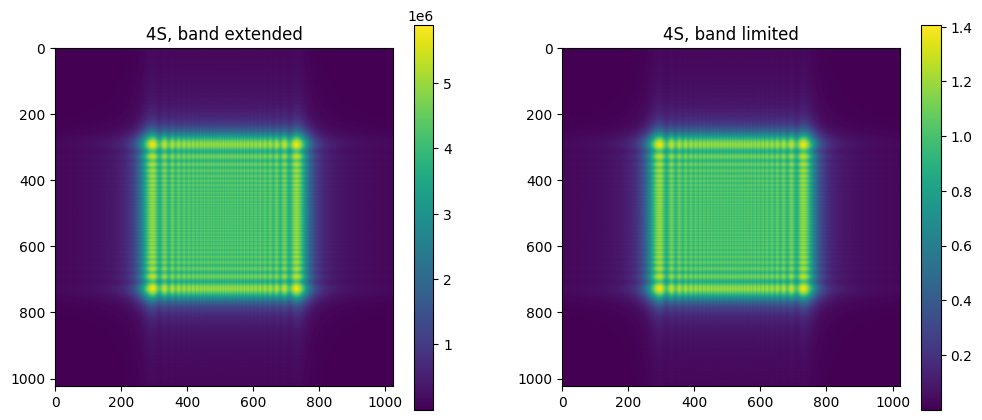

PSNR :  69.39364624023438


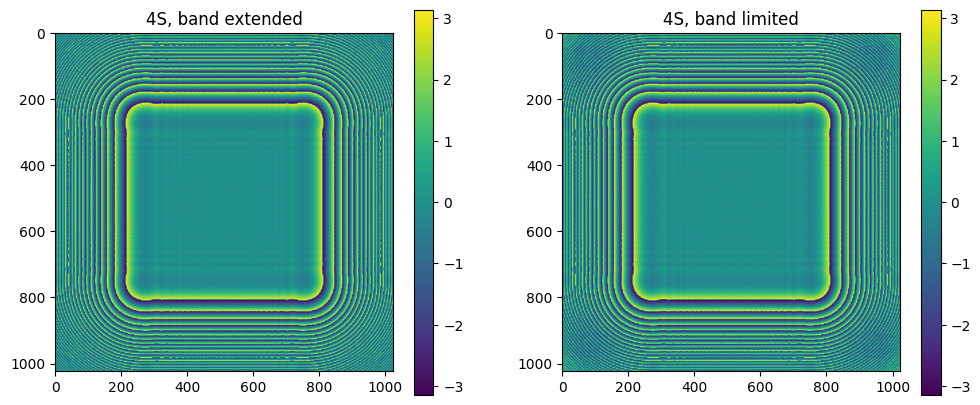

In [59]:
compare_BE_BL(4)

torch.Size([2048, 2048]) torch.Size([2, 4194304])
torch.Size([1, 1, 4194304]) torch.Size([2, 4194304])


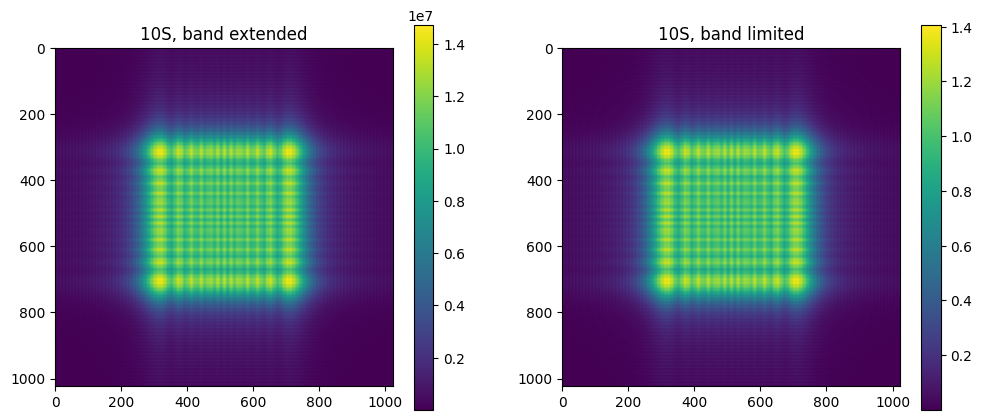

PSNR :  64.10576629638672


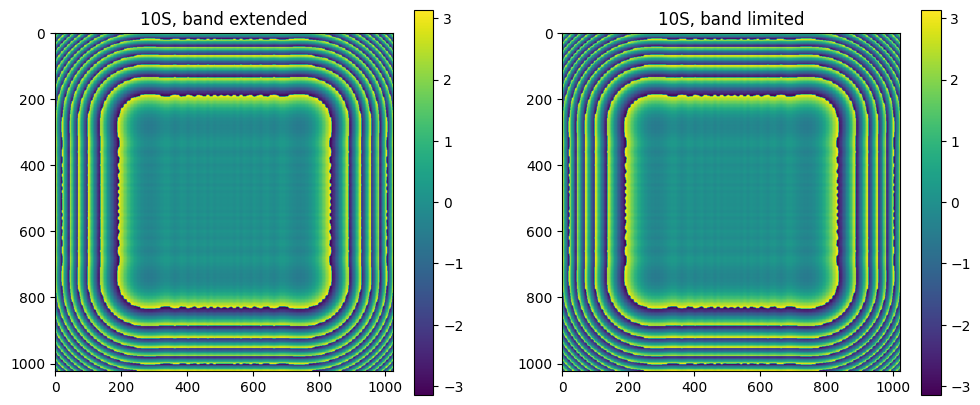

In [60]:
compare_BE_BL(10)

torch.Size([2048, 2048]) torch.Size([2, 4194304])
torch.Size([1, 1, 4194304]) torch.Size([2, 4194304])


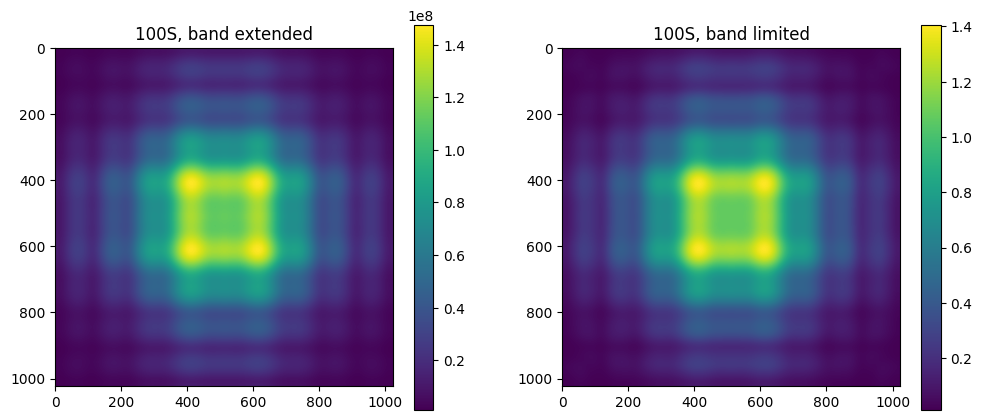

PSNR :  47.78459930419922


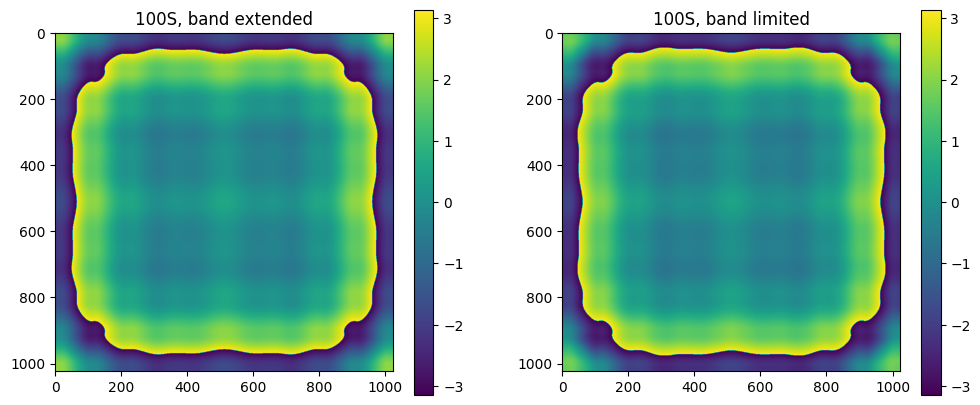

In [61]:
compare_BE_BL(100)

torch.Size([2048, 2048]) torch.Size([2, 4194304])
torch.Size([1, 1, 4194304]) torch.Size([2, 4194304])


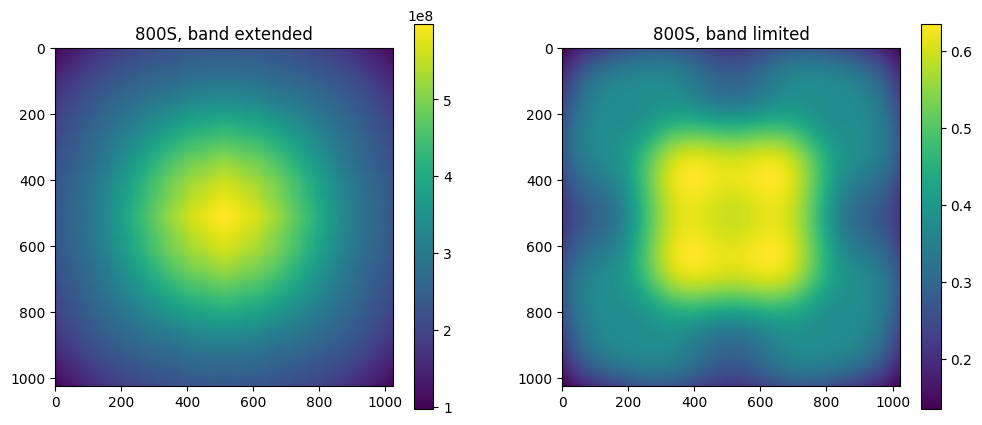

PSNR :  22.86431121826172


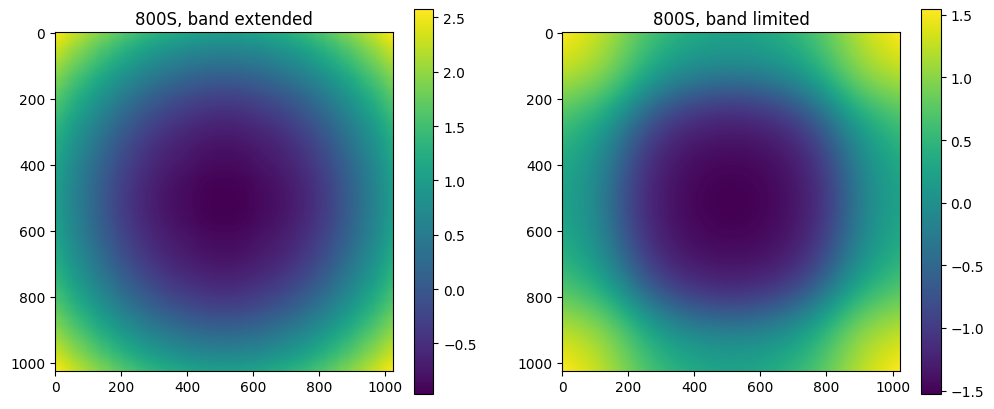

In [62]:
compare_BE_BL(800)